In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Personal_projects/Udacity/'

Mounted at /content/gdrive


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load processed datasets for trees

df_train = pd.read_csv(base_dir + "df_train_processed.csv")
df_test = pd.read_csv(base_dir + "df_test_processed.csv")

In [4]:
df_train_raw = pd.read_csv(base_dir + "df_train_raw.csv", parse_dates = ['EINGEFUEGT_AM'])
df_test_raw = pd.read_csv(base_dir + "df_test_raw.csv", parse_dates = ['EINGEFUEGT_AM'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [6]:
from fastai.tabular import *

In [7]:
def process_dates(df):
    df['EINGEFUEGT_YEAR'] = df['EINGEFUEGT_AM'].dt.year
    df['EINGEFUEGT_MONTH'] = df['EINGEFUEGT_AM'].dt.month
    df['EINGEFUEGT_DAY'] = df['EINGEFUEGT_AM'].dt.day
    df.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
    return df

In [8]:
# Reorder rows

#df_train_raw = df_train_raw.sample(frac=1).reset_index(drop=True)

In [9]:
cols_zero_is_unknown = ['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ' , 'GEBAEUDETYP',
                        'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
                        'REGIOTYP', 'RETOURTYP_BK_S' ,'SEMIO_DOM', 'TITEL_KZ', 'WOHNDAUER_2008',
                        'WOHNLAGE', 'W_KEIT_KIND_HH']

#'HAUSHALTSSTRUKTUR', 'GEOSCORE_KLS7

In [10]:
df_train_raw = process_dates(df_train_raw)
df_test_raw = process_dates(df_test_raw)

# Blank out unknowns for same treatment as blanks, how to treat zeroes??
#df_train_raw.replace({'-1':np.nan, -1:np.nan}, inplace=True)
#df_test_raw.replace({'-1':np.nan, -1:np.nan}, inplace=True)

#df_train_raw[cols_zero_is_unknown].replace({0:np.nan}, inplace=True)
#df_test_raw[cols_zero_is_unknown].replace({0:np.nan}, inplace=True)

df_train_raw.replace(to_replace=-1, value=np.nan, inplace=True)
df_train_raw.replace(to_replace='-1', value=np.nan, inplace=True)
df_train_raw[cols_zero_is_unknown].replace(to_replace=0, value=np.nan, inplace=True)
df_train_raw[cols_zero_is_unknown].replace(to_replace='0', value=np.nan, inplace=True)

df_test_raw.replace(to_replace=-1, value=np.nan, inplace=True)
df_test_raw.replace(to_replace='-1', value=np.nan, inplace=True)
df_test_raw[cols_zero_is_unknown].replace(to_replace=0, value=np.nan, inplace=True)
df_test_raw[cols_zero_is_unknown].replace(to_replace='0', value=np.nan, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [11]:
# Processing and validation splits
procs = [FillMissing, Categorify, Normalize]
#valid_idx = range(len(df_train_raw)-10000, len(df_train_raw))

In [12]:
# Consolidated fields

dep_var = 'RESPONSE'
top_vars = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'D19_KONSUMTYP', 'LNR', 'EINGEZOGENAM_HH_JAHR', 'ALTERSKATEGORIE_GROB']
top_vars = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'D19_KONSUMTYP', 'LNR', 'EINGEZOGENAM_HH_JAHR', 'ALTERSKATEGORIE_GROB', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12']

df_train_raw = df_train_raw[top_vars + [dep_var]]
cont_fields = list(set(df_train_raw.columns) - {dep_var})
category_fields = []

In [13]:
df_train_raw

,D19_SOZIALES,D19_KONSUMTYP_MAX,D19_KONSUMTYP,LNR,EINGEZOGENAM_HH_JAHR,ALTERSKATEGORIE_GROB,D19_VERSAND_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,RESPONSE
0,1.0,2,3.0,1763,2004.0,4,0.0,0.0,0.0,0
1,5.0,4,1.0,1771,1994.0,3,0.0,0.0,0.0,0
2,2.0,2,2.0,1776,1997.0,4,0.0,0.0,0.0,0
3,1.0,2,3.0,1460,1994.0,4,0.0,0.0,0.0,0
4,1.0,2,2.0,1783,1994.0,3,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
42957,3.0,2,1.0,66338,2010.0,4,6.0,6.0,0.0,0
42958,1.0,2,2.0,67629,2001.0,3,7.0,7.0,0.0,0
42959,1.0,2,2.0,68273,1994.0,4,0.0,0.0,0.0,0
42960,0.0,1,4.0,68581,1994.0,4,10.0,10.0,0.0,0


In [14]:
#All fields

#dep_var = 'RESPONSE'
#obj_fields = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']

# Use mostly continuous vars
#category_fields = obj_fields
#cont_fields = list(set(df_train_raw.columns) - set(category_fields))

# Use mostly categorical vars
#category_fields = ['LNR', 'AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CAMEO_DEU_2015',
#                  'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER',
#                  'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST',
#                  'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
#                  'RETOURTYP_BK_S', 'TITEL_KZ', 'ZABEOTYP']

#D19_KK_KUNDENTYP, HAUSHALTSSTRUKTUR
#category_fields = category_fields + obj_fields
#cont_fields = list(set(df_train_raw.columns) - set(category_fields) - {dep_var})

In [15]:
categories = df_train_raw[category_fields].nunique().keys().to_list()
cardinalities = df_train_raw[category_fields].nunique().values
emb_inputs = {cat: min(50, card//2) for cat, card in zip(categories, cardinalities)}
emb_inputs

{}

In [16]:
#data = TabularDataBunch.from_df(path='', df=df_train_raw, dep_var=dep_var, valid_idx=valid_idx, procs=procs, cat_names=category_fields, cont_names=cont_fields)#

In [17]:
data = (TabularList.from_df(df=df_train_raw, path='', cat_names=category_fields, procs=procs, cont_names=cont_fields)
                              .split_by_rand_pct(valid_pct=0.35)
                              .label_from_df(cols=dep_var)
                              .add_test(TabularList.from_df(df_test_raw))
                              .databunch())

In [18]:
#learner_final = tabular_learner(data, layers=[50,10], metrics=[accuracy, AUROC()], ps=[0.5,0.2], emb_szs=emb_inputs, emb_drop=0.04)
learner_final = tabular_learner(data, layers=[100,20], metrics=[accuracy, AUROC()], ps=[0.1,0.1], emb_szs=emb_inputs, emb_drop=0.1)

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E+00
Min loss divided by 10: 6.31E-02


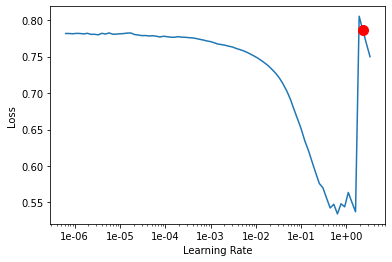

In [19]:
learner_final.lr_find()
learner_final.recorder.plot(suggestion=True)

In [20]:
min_grad_lr = min(learner_final.recorder.min_grad_lr,1e-01)

In [21]:
learner_final.fit_one_cycle(5, max_lr=min_grad_lr)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.071622,0.059899,0.988428,0.762949,00:06
1,0.073073,0.062628,0.988428,0.735964,00:06
2,0.068047,0.077451,0.988428,0.776532,00:06
3,0.069958,0.058892,0.988428,0.775264,00:06
4,0.053419,0.057049,0.988428,0.771772,00:05


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [22]:
learner_final.fit_one_cycle(5, max_lr=min_grad_lr/5)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.064861,0.057411,0.988428,0.774587,00:06
1,0.062857,0.058032,0.988428,0.784854,00:06
2,0.067069,0.057461,0.988428,0.782431,00:05
3,0.072994,0.057839,0.988361,0.784224,00:06
4,0.058457,0.173493,0.987630,0.782664,00:05


In [23]:
learner_final.fit_one_cycle(5, max_lr=min_grad_lr/10)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.067217,0.065501,0.987962,0.783076,00:06
1,0.071013,0.057898,0.988428,0.782803,00:05
2,0.057179,0.068895,0.987630,0.781905,00:05
3,0.058651,0.056766,0.988428,0.784669,00:06
4,0.068188,0.057619,0.988361,0.785934,00:06


In [24]:
#learner_final.save(base_dir + 'neural_net')

In [25]:
#learner_final.load(base_dir + 'neural_net')

In [26]:
preds_nn, y = learner_final.get_preds(DatasetType.Test)
test_submission = pd.concat([df_test_raw[['LNR']], pd.DataFrame(preds_nn.numpy())[[1]]],axis=1)
test_submission.columns = ['LNR', 'RESPONSE']
test_submission.head()

,LNR,RESPONSE
0,1754,0.031476
1,1770,0.035442
2,1465,0.002510
3,1470,0.002510
4,1478,0.003530


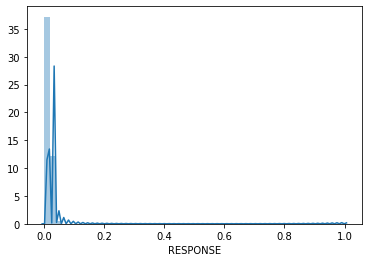

In [27]:
sns.distplot(test_submission['RESPONSE'])

In [28]:
test_submission.to_csv(base_dir + "test_submission.csv", index=False)

# Model ensembling

In [29]:
best_rf = pickle.load(open(base_dir +'best_rf.sav', 'rb'))
preds_rf = best_rf.predict_proba(df_test)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.22.2.post1. This might lead to break

In [30]:
preds_ens = (preds_rf + preds_nn.numpy()[:,1])/2

In [31]:
ens_submission = pd.concat([df_test_raw[['LNR']], pd.DataFrame(preds_ens)],axis=1)
ens_submission.columns = ['LNR', 'RESPONSE']
ens_submission.head()

,LNR,RESPONSE
0,1754,0.366172
1,1770,0.383582
2,1465,0.085124
3,1470,0.095897
4,1478,0.097854


In [32]:
ens_submission.to_csv(base_dir + "ensemble_submission.csv", index=False)

In [33]:
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/